In [1]:
# import modules
import os
import pandas as pd
import numpy as np
import random
import pickle

# import scikit-learn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score, precision_recall_curve, auc, roc_curve

# import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# save path
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DRIVE_PATH'] + '/' + '/'.join(folders) + '/' + fname)

training_file_path = get_data_path(['SL PRED', 'input'], 'ito_pairs_annotated_final.csv')
old_classifier_path = get_data_path(['SL PRED', 'input'], 'processed_DeKegel_TableS8.csv')

# Testing sets
parrish_file_path = get_data_path(['SL PRED', 'NEW'], 'parrish_pairs_annotated.csv')
klingbeil_file_path = get_data_path(['SL PRED', 'NEW'], 'klingbeil_pairs_annotated.csv')
file_path_36kdataset = get_data_path(['SL PRED', 'input', 'NEW'], '36Kdataset_all.csv')

# Output
file_RF_model_early = get_data_path(['SL PRED', 'output'], 'RF_model_early_final.pickle')
file_RF_model_late = get_data_path(['SL PRED', 'output'], 'RF_model_late_final.pickle')

figure_path_roc_auc = get_data_path(['SL PRED', 'NEW', 'cleanNA'], 'roc_auc.png')
figure_path_pr_auc = get_data_path(['SL PRED', 'NEW', 'cleanNA'], 'pr_auc.png')

In [3]:
training_df = pd.read_csv(training_file_path)
training_df[:3]

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,zA1_rank,A2_rank,zA2_rank,max_ranked_A1A2,min_ranked_A1A2,z_max_ranked_A1A2,z_min_ranked_A1A2,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,-0.759628,NaN,NaN,5108.0,5108.0,-0.759628,-0.759628,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.303431,NaN,NaN,9125.0,9125.0,0.303431,0.303431,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,-1.036177,NaN,NaN,4063.0,4063.0,-1.036177,-1.036177,0.024593,0.069772,False


In [4]:
old_classifier_training_df = pd.read_csv(old_classifier_path)
old_classifier_training_df[:3]

,prediction_rank,prediction_percentile,old_genepair,genepair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,...,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,A1_entrez_new,A2_entrez_new,A1_new,A2_new,A1_ensembl_new,A2_ensembl_new
0,1,0.1,SMARCA2_SMARCA4,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,...,0.225382,0.627875,18.609973,34.302868,6595.0,6597,SMARCA2,SMARCA4,ENSG00000080503,ENSG00000127616
1,2,0.1,EXOC6_EXOC6B,EXOC6_EXOC6B,EXOC6,EXOC6B,54536,23233,ENSG00000138190,ENSG00000144036,...,0.285886,0.069456,6.390812,11.168367,54536.0,23233,EXOC6,EXOC6B,ENSG00000138190,ENSG00000144036
2,3,0.1,STAG1_STAG2,STAG1_STAG2,STAG1,STAG2,10274,10735,ENSG00000118007,ENSG00000101972,...,0.329993,0.854086,13.103716,22.097616,10274.0,10735,STAG1,STAG2,ENSG00000118007,ENSG00000101972


In [ ]:
late_features_df = old_classifier_training_df[['genepair', 'A1_entrez_new', 'A2_entrez_new', 'prediction_score', 'min_sequence_identity', 'closest', 'WGD', 'family_size', 'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog',
                                            'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog', 'has_essential_cerevisiae_ortholog', 'conservation_score', 'mean_age', 'either_in_complex', 'mean_complex_essentiality', 'colocalisation',
                                            'interact', 'n_total_ppi', 'fet_ppi_overlap','gtex_spearman_corr', 'gtex_min_mean_expr', 'gtex_max_mean_expr']]
late_features_df = late_features_df.rename(columns={'A1_entrez_new':'A1_entrez', 'A2_entrez_new': 'A2_entrez'})

In [6]:
def integrate_features(df, features_df):
    integrated_df = pd.merge(df, features_df, 
                             left_on=['genepair', 'A1_entrez', 'A2_entrez'], 
                             right_on=['genepair', 'A1_entrez', 'A2_entrez'], 
                             how='left')
    bool_cols = ['closest', 'WGD', 'has_pombe_ortholog', 'has_essential_cerevisiae_ortholog', 'either_in_complex', 'interact']
    integrated_df[bool_cols] = integrated_df[bool_cols].astype(bool)
    return integrated_df

In [7]:
integrated_training_df = integrate_features(training_df, late_features_df)
integrated_training_df[:3]

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,mean_age,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702


In [9]:
files = [parrish_file_path, klingbeil_file_path]
crispr_screens_df = [pd.read_csv(file) for file in files]

In [10]:
for i, df in enumerate(crispr_screens_df):
    integrated_df = integrate_features(df, late_features_df)
    crispr_screens_df[i] = integrated_df

In [11]:
test_df = pd.read_csv(file_path_36kdataset)
test_df = integrate_features(test_df, late_features_df)
test_df = test_df.rename(columns={'SL':'SL_new'})
test_df[:3]

,genepair,org_genepair,org_A1,org_A2,cell_line,DepMap_ID,SL_new,A1,A2,A1_entrez,...,mean_age,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A1BG_OSCAR,A1BG_OSCAR,A1BG,OSCAR,NCIH1299,ACH-000510,0,A1BG,OSCAR,1,...,210.95,False,0.0,0.0,False,22,0.0,0.273243,9.456192,10.980585
1,A1BG_OSCAR,A1BG_OSCAR,A1BG,OSCAR,MDAMB231,ACH-000768,0,A1BG,OSCAR,1,...,210.95,False,0.0,0.0,False,22,0.0,0.273243,9.456192,10.980585
2,A1BG_TARM1,A1BG_TARM1,A1BG,TARM1,NCIH1299,ACH-000510,0,A1BG,TARM1,1,...,97.40,False,0.0,0.0,False,22,0.0,-0.009277,0.117874,9.456192


In [12]:
feature_columns_1 = ['rMaxExp_A1A2', 'rMinExp_A1A2',
                     'max_ranked_A1A2', 'min_ranked_A1A2',
                     'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 
                    # 'max_seq_id', 'min_seq_id', 
                     'prediction_score', 'min_sequence_identity',
                     'ranked_Essentiality_weighted_PPI', 'Expression_weighted_PPI',
                     'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess',
                     'smallest_gene_expression', 'smallest_GO_CC_expression'
                     ]

target_column = 'SL_new'

print('num of features:', len(feature_columns_1))

num of features: 16


In [13]:
feature_columns_2 = feature_columns_1 + ['closest', 'WGD', 'family_size',
                                         'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog',
                                         'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog',
                                         'has_essential_cerevisiae_ortholog', 'conservation_score', 'mean_age',
                                         'either_in_complex', 'mean_complex_essentiality', 'colocalisation',
                                         'interact', 'n_total_ppi', 'fet_ppi_overlap',
                                         'gtex_spearman_corr', 'gtex_min_mean_expr', 'gtex_max_mean_expr']
feature_columns_2.remove('prediction_score')
print('num of features:', len(feature_columns_2))

num of features: 35


In [14]:
def preprocess_dataset(df, old_df,
                       required_genepairs_col='genepair',
                       dropna_cols=None,
                       fillna_zero_cols=None,
                       fillna_large_cols=None,
                       fillna_large_value=18000):
    """
    Preprocess a training or testing dataset:
    - Keep only rows with genepairs present in `old_df`
    - Drop rows with NaN in specific columns
    - Fill missing values with default values
    
    Parameters:
        df (pd.DataFrame): Dataset to process
        old_df (pd.DataFrame): Dataset with allowed genepairs
        required_genepairs_col (str): Column name for genepairs to match
        dropna_cols (list): Columns for which rows with NaNs should be dropped
        fillna_zero_cols (list): Columns to fill NaNs with 0
        fillna_large_cols (list): Columns to fill NaNs with large constant
        fillna_large_value (int or float): The large value to fill (default: 18000)

    Returns:
        pd.DataFrame: Cleaned and processed DataFrame
    """

    # Step 1: Filter rows to only those in old_df
    df_filtered = df[df[required_genepairs_col].isin(old_df[required_genepairs_col])].copy()

    # Step 2: Drop rows with any NA in required columns
    if dropna_cols:
        df_filtered = df_filtered.dropna(axis=0, how='any', subset=dropna_cols)

    # Step 3: Fill NaNs with 0 or large number
    if fillna_zero_cols:
        df_filtered[fillna_zero_cols] = df_filtered[fillna_zero_cols].fillna(0)

    if fillna_large_cols:
        df_filtered[fillna_large_cols] = df_filtered[fillna_large_cols].fillna(fillna_large_value)

    # Step 4: Reset index for clean result
    return df_filtered.reset_index(drop=True)


In [15]:
drop_na_values = ['rMaxExp_A1A2', 'rMinExp_A1A2', 'max_ranked_A1A2', 'min_ranked_A1A2']
fillna_values = ['Expression_weighted_PPI', 'smallest_gene_expression', 'smallest_GO_CC_expression']
fillna_values_v2 = ['ranked_Essentiality_weighted_PPI', 'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess']

# Apply to training set
integrated_training_df_clean = preprocess_dataset(
    df=integrated_training_df,
    old_df=old_classifier_training_df,
    dropna_cols=drop_na_values,
    fillna_zero_cols=fillna_values,
    fillna_large_cols=fillna_values_v2
)

# Similarly for test set (if needed):
# integrated_test_df_clean = preprocess_dataset(
#     df=integrated_test_df,
#     old_df=old_classifier_training_df,
#     dropna_cols=drop_na_values,
#     fillna_zero_cols=fillna_values,
#     fillna_large_cols=fillna_values_v2
# )


In [16]:
display(integrated_training_df_clean.loc[[2244, 2245, 2246, 2247],'ranked_Essentiality_weighted_PPI'])
display(integrated_training_df_clean[:3])

2244    18000.0
2245    18000.0
2246    18000.0
2247    18000.0
Name: ranked_Essentiality_weighted_PPI, dtype: float64

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,mean_age,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702


In [ ]:
#impute_features = ['ranked_Essentiality_weighted_PPI', 'Expression_weighted_PPI', 'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess', 'smallest_gene_expression', 'smallest_GO_CC_expression']

#integrated_training_df = integrated_training_df.copy()

#integrated_training_df[impute_features] = integrated_training_df.groupby("DepMap_ID")[impute_features].transform(lambda x: x.fillna(x.mean()))

In [17]:
#remove NA values before training the model
#drop_na_values = ['rMaxExp_A1A2', 'rMinExp_A1A2', 'max_ranked_A1A2', 'min_ranked_A1A2']
#integrated_training_df_clean = integrated_training_df.dropna(axis=0, how='any', subset=drop_na_values).reset_index(drop=True)

#integrated_training_df_clean = integrated_training_df.copy()

#summary of the training dataset after removing NA values
print('Num SL:', integrated_training_df_clean[integrated_training_df_clean[target_column] == True].shape[0], '/', integrated_training_df_clean.shape[0])
print('Num non-SL:', integrated_training_df_clean[integrated_training_df_clean[target_column] == False].shape[0], '/', integrated_training_df_clean.shape[0])
print(f'Number of unique gene pairs: {integrated_training_df_clean.genepair.nunique()}')
print(f'Number of unique cell lines: {integrated_training_df_clean.cell_line.nunique()}')
integrated_training_df_clean[:3]

Num SL: 958 / 41244
Num non-SL: 40286 / 41244
Number of unique gene pairs: 4170
Number of unique cell lines: 10


,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,mean_age,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702


In [ ]:
integrated_training_df_clean[feature_columns_2].isna().sum()

In [ ]:
#integrated_training_df_clean.to_csv(get_data_path(['SL PRED', 'NEW', 'NA'], 'integrated_training_df_clean.csv'), index=False)

In [18]:
tdf = crispr_screens_df[0]

print('Parrish Screen')
print(f'Number of SL and non-SL rows:')
print(f'SL: {tdf[tdf[target_column] == True].shape[0]}')
print(f'non SL: {tdf[tdf[target_column] == False].shape[0]}')
print(f'Number of unique gene pairs: {tdf.genepair.nunique()}')
print(f'Number of unique cell lines: {tdf.cell_line.nunique()}')

tdf = crispr_screens_df[1]

print('')
print('Klingbeil Screen')
print(f'Number of SL and non-SL rows:')
print(f'SL: {tdf[tdf[target_column] == True].shape[0]}')
print(f'non SL: {tdf[tdf[target_column] == False].shape[0]}')
print(f'Number of unique gene pairs: {tdf.genepair.nunique()}')
print(f'Number of unique cell lines: {tdf.cell_line.nunique()}')

tdf = test_df

print('')
print('36K Screen')
print(f'Number of SL and non-SL rows:')
print(f'SL: {tdf[tdf[target_column] == True].shape[0]}')
print(f'non SL: {tdf[tdf[target_column] == False].shape[0]}')
print(f'Number of unique gene pairs: {tdf.genepair.nunique()}')
print(f'Number of unique cell lines: {tdf.cell_line.nunique()}')


Parrish Screen
Number of SL and non-SL rows:
SL: 141
non SL: 1654
Number of unique gene pairs: 911
Number of unique cell lines: 2

Klingbeil Screen
Number of SL and non-SL rows:
SL: 2009
non SL: 50878
Number of unique gene pairs: 2254
Number of unique cell lines: 22

36K Screen
Number of SL and non-SL rows:
SL: 125
non SL: 65697
Number of unique gene pairs: 32886
Number of unique cell lines: 2


In [19]:
# Apply to training set
crispr_screens_df[0] = preprocess_dataset(
    df=crispr_screens_df[0],
    old_df=old_classifier_training_df,
    dropna_cols=drop_na_values,
    fillna_zero_cols=fillna_values,
    fillna_large_cols=fillna_values_v2
)

crispr_screens_df[1] = preprocess_dataset(
    df=crispr_screens_df[1],
    old_df=old_classifier_training_df,
    dropna_cols=drop_na_values,
    fillna_zero_cols=fillna_values,
    fillna_large_cols=fillna_values_v2
)

test_df = preprocess_dataset(
    df=test_df,
    old_df=old_classifier_training_df,
    dropna_cols=drop_na_values,
    fillna_zero_cols=fillna_values,
    fillna_large_cols=fillna_values_v2
)

In [ ]:
""" crispr_screens_df[0] = crispr_screens_df[0].copy()

crispr_screens_df[0] = crispr_screens_df[0].dropna(axis=0, how='any', subset=drop_na_values).reset_index(drop=True)

#summary of the training dataset after removing NA values
print('parrish')
print('Num SL:', crispr_screens_df[0][crispr_screens_df[0][target_column] == True].shape[0], '/', crispr_screens_df[0].shape[0])

crispr_screens_df[1] = crispr_screens_df[1].copy()

crispr_screens_df[1] = crispr_screens_df[1].dropna(axis=0, how='any', subset=drop_na_values).reset_index(drop=True)

#summary of the training dataset after removing NA values
print('klingbeil')
print('Num SL:', crispr_screens_df[1][crispr_screens_df[1][target_column] == True].shape[0], '/', crispr_screens_df[1].shape[0])

test_df = test_df.copy()

test_df = test_df.dropna(axis=0, how='any', subset=drop_na_values).reset_index(drop=True)

#summary of the training dataset after removing NA values
print('36Kdataset')
print('Num SL:', test_df[test_df[target_column] == True].shape[0], '/', test_df.shape[0]) """

In [ ]:
""" crispr_screens_df[0] = crispr_screens_df[0].copy()

crispr_screens_df[0][impute_features] = crispr_screens_df[0].groupby("DepMap_ID")[impute_features].transform(lambda x: x.fillna(x.mean()))

crispr_screens_df[0] = crispr_screens_df[0].dropna(axis=0, how='any', subset=feature_columns_2 + [target_column]).reset_index(drop=True)

#summary of the training dataset after removing NA values
print('parrish')
print('Num SL:', crispr_screens_df[0][crispr_screens_df[0][target_column] == True].shape[0], '/', crispr_screens_df[0].shape[0])

crispr_screens_df[1] = crispr_screens_df[1].copy()

crispr_screens_df[1][impute_features] = crispr_screens_df[1].groupby("DepMap_ID")[impute_features].transform(lambda x: x.fillna(x.mean()))

crispr_screens_df[1] = crispr_screens_df[1].dropna(axis=0, how='any', subset=feature_columns_2 + [target_column]).reset_index(drop=True)

#summary of the training dataset after removing NA values
print('klingbeil')
print('Num SL:', crispr_screens_df[1][crispr_screens_df[1][target_column] == True].shape[0], '/', crispr_screens_df[1].shape[0])

test_df = test_df.copy()

test_df[impute_features] = test_df.groupby("DepMap_ID")[impute_features].transform(lambda x: x.fillna(x.mean()))

test_df = test_df.dropna(axis=0, how='any', subset=feature_columns_2 + [target_column]).reset_index(drop=True)

#summary of the training dataset after removing NA values
print('36Kdataset')
print('Num SL:', test_df[test_df[target_column] == True].shape[0], '/', test_df.shape[0]) """

### Unseen Validation Data

In [20]:
parrish_all = crispr_screens_df[0]

common_genepairs = set(parrish_all['genepair']).intersection(set(integrated_training_df_clean['genepair']))
uncommon_genepairs = set(parrish_all['genepair']).difference(set(integrated_training_df_clean['genepair']))

parrish_seen_pairs_df = parrish_all.loc[parrish_all['genepair'].isin(common_genepairs)] # seen pairs
parrish_unseen_pairs_df = parrish_all.loc[parrish_all['genepair'].isin(uncommon_genepairs)] # unseen pairs

# summary of the unseen validation dataset
assert parrish_unseen_pairs_df.shape[0] + parrish_seen_pairs_df.shape[0] == parrish_all.shape[0]

In [21]:
klingbeil_all = crispr_screens_df[1]

common_genepairs = set(klingbeil_all['genepair']).intersection(set(integrated_training_df_clean['genepair']))
uncommon_genepairs = set(klingbeil_all['genepair']).difference(set(integrated_training_df_clean['genepair']))

common_celllines = set(klingbeil_all['DepMap_ID']).intersection(set(integrated_training_df_clean['DepMap_ID']))
uncommon_celllines = set(klingbeil_all['DepMap_ID']).difference(set(integrated_training_df_clean['DepMap_ID']))

print('common_genepairs:', len(common_genepairs))
print('common_celllines:', len(common_celllines))
print('#################')
print('#################')
print('uncommon_genepairs:', len(uncommon_genepairs))
print('uncommon_celllines:', len(uncommon_celllines))

klingbeil_seen_pairs_df = klingbeil_all.loc[klingbeil_all['genepair'].isin(common_genepairs), ] # seen pairs
klingbeil_seen_pairs_df = klingbeil_seen_pairs_df.loc[klingbeil_seen_pairs_df['DepMap_ID'].isin(common_celllines), ] 

klingbeil_unseen_pairs_df = klingbeil_all.loc[klingbeil_all['genepair'].isin(uncommon_genepairs), ] # unseen pairs
klingbeil_unseen_pairs_df = klingbeil_unseen_pairs_df.loc[klingbeil_unseen_pairs_df['DepMap_ID'].isin(uncommon_celllines), ] 

common_genepairs: 1012
common_celllines: 1
#################
#################
uncommon_genepairs: 692
uncommon_celllines: 20


In [22]:
common_genepairs = set(test_df['genepair']).intersection(set(integrated_training_df_clean['genepair']))
uncommon_genepairs = set(test_df['genepair']).difference(set(integrated_training_df_clean['genepair']))

common_celllines = set(test_df['DepMap_ID']).intersection(set(integrated_training_df_clean['DepMap_ID']))
uncommon_celllines = set(test_df['DepMap_ID']).difference(set(integrated_training_df_clean['DepMap_ID']))

print('common_genepairs:', len(common_genepairs))
print('common_celllines:', len(common_celllines))
print('#################')
print('#################')
print('uncommon_genepairs:', len(uncommon_genepairs))
print('uncommon_celllines:', len(uncommon_celllines))

unseen_test_df = test_df.loc[test_df['genepair'].isin(uncommon_genepairs), ] # unseen pairs
unseen_test_df = unseen_test_df.loc[unseen_test_df['DepMap_ID'].isin(uncommon_celllines), ] 

common_genepairs: 4125
common_celllines: 0
#################
#################
uncommon_genepairs: 26567
uncommon_celllines: 2


### Run RF Classifier


In [23]:
def calc_auc(df, RF, feature_columns, target_column):
    ypred = RF.predict_proba(df[feature_columns])[:,1]
    auc_pr_df = pd.DataFrame({
        'SL':df[target_column],
        'ypred':ypred,
        'prediction_score':df['prediction_score'],
        'rMinExp_A1A2': df['rMinExp_A1A2'],
        'min_ranked_A1A2': df['min_ranked_A1A2'],
        'transformed_gene_essentiality': -df['min_ranked_A1A2'],
        'max_seq_id': df['max_seq_id']})
    return auc_pr_df

In [24]:
# Define feature sets
data_1 = integrated_training_df_clean[feature_columns_1]
data_2 = integrated_training_df_clean[feature_columns_2]
target = integrated_training_df_clean[target_column]

In [25]:
RF = RandomForestClassifier(n_estimators=600, random_state=8, max_features=0.2, max_depth=20, min_samples_leaf=4)

In [ ]:
#RFearly = RandomForestClassifier(n_estimators=600, random_state=42, max_features=0.4, max_depth=7, min_samples_leaf=4)
#RFlate = RandomForestClassifier(n_estimators=600, random_state=42, max_features=0.2, max_depth=7, min_samples_leaf=4)

In [26]:
early = RF.fit(data_1, target)

In [27]:
with open(file_RF_model_early, 'wb') as f:
    pickle.dump(early, f)

In [ ]:
# Load RF classifier from file
with open(file_RF_model_early, 'rb') as file:
    early = pickle.load(file)

In [28]:
auc_pr_data_all_early = []
auc_pr_data_all_early.append(calc_auc(parrish_seen_pairs_df, early, feature_columns_1, target_column))
auc_pr_data_all_early.append(calc_auc(parrish_unseen_pairs_df, early, feature_columns_1, target_column))
auc_pr_data_all_early.append(calc_auc(klingbeil_seen_pairs_df, early, feature_columns_1, target_column))
auc_pr_data_all_early.append(calc_auc(klingbeil_unseen_pairs_df, early, feature_columns_1, target_column))
auc_pr_data_all_early.append(calc_auc(test_df, early, feature_columns_1, target_column))
auc_pr_data_all_early.append(calc_auc(unseen_test_df, early, feature_columns_1, target_column))

In [29]:
late = RF.fit(data_2, target)

In [30]:
with open(file_RF_model_late, 'wb') as f:
    pickle.dump(late, f)

In [ ]:
# Load RF classifier from file
with open(file_RF_model_late, 'rb') as file:
    late = pickle.load(file)

In [31]:
auc_pr_data_all_late = []
auc_pr_data_all_late.append(calc_auc(parrish_seen_pairs_df, late, feature_columns_2, target_column))
auc_pr_data_all_late.append(calc_auc(parrish_unseen_pairs_df, late, feature_columns_2, target_column))
auc_pr_data_all_late.append(calc_auc(klingbeil_seen_pairs_df, late, feature_columns_2, target_column))
auc_pr_data_all_late.append(calc_auc(klingbeil_unseen_pairs_df, late, feature_columns_2, target_column))
auc_pr_data_all_late.append(calc_auc(test_df, late, feature_columns_2, target_column))
auc_pr_data_all_late.append(calc_auc(unseen_test_df, late, feature_columns_2, target_column))

In [32]:
validation_data_df = []
for i in range(6):
    early_df = auc_pr_data_all_early[i].loc[:, ['SL', 'ypred', 'prediction_score', 'max_seq_id']]
    late_df = auc_pr_data_all_late[i].loc[:, ['SL', 'ypred']]
    concat_df = pd.concat([early_df.rename(columns={'SL':'SL_early',
                                                    'ypred':'ypred_early'}), 
                          late_df.rename(columns={'SL':'SL_late',
                                                  'ypred':'ypred_late'})], axis=1)
    validation_data_df.append(concat_df)

## Draw ROC and PR Curves

In [33]:
def plot_roc_curve(ax, data, true_label, probas, label, color,
                   line_style="solid", draw_style="steps-post", zorder=10, labels_only=False):

    # Drop rows with NaNs in true or predicted columns
    valid_data = data[[true_label, probas]].dropna()

    # Make sure we have enough valid data to compute ROC
    y_true = valid_data[true_label].values
    y_score = valid_data[probas].values

    if len(np.unique(y_true)) < 2:
        print(f"Skipping {label}: not enough class variation after dropping NaNs.")
        return

    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    legend_label = f"{roc_auc:.2f}"
    ax.step(fpr, tpr, label=legend_label, color=color,
            linestyle=line_style, drawstyle=draw_style, zorder=zorder, linewidth=1.25)

def draw_roc_curves(data, true_labels, probas, labels, title, colors, ax, labels_only=False):
    for true_label, probas, label, color in zip(true_labels, probas, labels, colors):
        plot_roc_curve(ax, data, true_label, probas, label, color, labels_only=labels_only)

    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='0.50')
    # ax.set_xlabel('False Positive Rate', fontsize=16)
    # ax.set_ylabel('True Positive Rate', fontsize=16)
    # ax.set_title(f'{title}', fontsize=14)
    # ax.tick_params(axis='x', labelsize=8)
    # ax.tick_params(axis='y', labelsize=8)
    # ax.spines.top.set(visible=False)
    # ax.spines.right.set(visible=False)
    # ax.set_ylim([-0.025, 1.025])
    # ax.set_xlim([-0.025, 1.025])
    # ax.legend(loc='lower right', fontsize=16)

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{title}', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.spines.top.set(visible=False)
    ax.spines.right.set(visible=False)
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlim([-0.025, 1.025])
    ax.legend(loc='lower right', fontsize=10)

def draw_validation_curves(validation_data_df, title_list):#, figure_path):
    sns.set_context('paper')
    #fig, ax = plt.subplots(1, 6, figsize=(22, 5))  # 5 subplots for each validation dataset
    fig, ax = plt.subplots(1, 4, figsize=(11.85, 3.75))  # 5 subplots for each validation dataset

    true_labels = ['SL_early', 'SL_late', 'SL_early', 'SL_early']
    predictions = ['ypred_early', 'ypred_late', 'prediction_score', 'max_seq_id']
    custom_labels = ['Context-Specific Classifier (early)', 'Context-Specific Classifier (late)', 'General Classifier', 'Sequence Identity']
    colors = ['#009E73', '#CC79A7', '#777777', '#E69F00']

    for i, df in enumerate(validation_data_df):
        draw_roc_curves(df, true_labels, predictions, custom_labels, title_list[i], colors, ax[i])

    # Extract handles and labels from the first subplot
    handles, labels = ax[0].get_legend_handles_labels()
    
    # Create a shared legend for the figure
    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.2], fontsize=20, fancybox=True, facecolor='#efefef', borderpad=0.5)

    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.1], fontsize=12, fancybox=True, facecolor='#efefef', borderpad=0.5)

    plt.tight_layout(h_pad=0.5)
    #plt.savefig(f"{figure_path}", bbox_inches='tight', dpi=500)
    #plt.close()
    plt.show()

# Example usage 
#dataset_names = ['CHyMErA screen', 'Dede et al.', 'Parrish et al.', 'Thompson et al.', 'Klingbeil et al.', 'Unseen Pairs']
#draw_validation_curves(validation_data_df, dataset_names, figure_path_roc_auc)

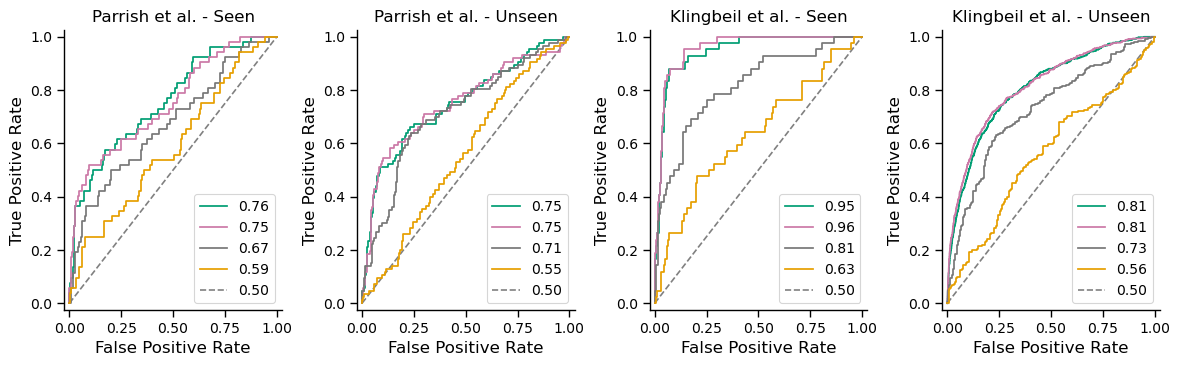

In [34]:
dataset_names = ['Parrish et al. - Seen', 'Parrish et al. - Unseen', 'Klingbeil et al. - Seen', 'Klingbeil et al. - Unseen']
draw_validation_curves(validation_data_df[0:4], dataset_names)#, figure_path_roc_auc)

In [ ]:
dataset_names = ['36K Dataset - Full', '36K Dataset - Unseen']
figure_path_roc_auc_36 = get_data_path(['SL PRED', 'NEW', 'NA'], 'roc_auc_val_36K_dataset.png')
draw_validation_curves(validation_data_df[4:6], dataset_names, figure_path_roc_auc_36)

In [ ]:
def plot_pr_curve(ax, data, true_label, probas, label, color,
                  line_style="solid", draw_style="default", zorder=10,
                  labels_only=False, subplot_index=None):
    # Drop rows with NaNs in either column
    valid_data = data[[true_label, probas]].dropna()

    y_true = valid_data[true_label].values
    y_score = valid_data[probas].values

    # Skip if there aren't enough valid samples or variation in labels
    if len(y_true) < 2 or len(np.unique(y_true)) < 2:
        print(f"Skipping {label}: insufficient valid data.")
        return

    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap_score = average_precision_score(y_true, y_score)
    legend_label = f"{ap_score:.2f}"

    ax.plot(recall, precision, label=legend_label, color=color,
            linestyle=line_style, drawstyle=draw_style, zorder=zorder, linewidth=1.25)

    # Optional: annotate with X marker on a fixed point
    # if subplot_index in [2, 3]:
    #     ax.scatter(0.325, 0.4, color='red', marker="X", s=70, zorder=15)


def draw_pr_curves(data, true_labels, probas, labels, title, colors, ax, labels_only=False, subplot_index=None):
    for true_label, probas, label, color in zip(true_labels, probas, labels, colors):
        plot_pr_curve(ax, data, true_label, probas, label, color, labels_only=labels_only, subplot_index=subplot_index)

    no_skill = sum(data[true_labels[0]]) / len(data[true_labels[0]])
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray', label=f'{no_skill:.2f}')
    # ax.set_xlabel('Recall', fontsize=16)
    # ax.set_ylabel('Precision', fontsize=16)
    # ax.set_title(f'{title}', fontsize=14)
    # ax.tick_params(axis='x', labelsize=8)
    # ax.tick_params(axis='y', labelsize=8)
    # ax.spines.top.set(visible=False)
    # ax.spines.right.set(visible=False)
    # ax.set_ylim([-0.025, 1.025])
    # ax.set_xlim([-0.025, 1.025])
    # ax.legend(loc='upper right', fontsize=16)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{title}', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.spines.top.set(visible=False)
    ax.spines.right.set(visible=False)
    ax.set_ylim([-0.025, 1.025])
    ax.set_xlim([-0.025, 1.025])
    ax.legend(loc='upper right', fontsize=10)

def draw_pr_validation_curves(validation_data_df, title_list, figure_path):
    sns.set_context('paper')
    #fig, ax = plt.subplots(1, 6, figsize=(22, 5))  # 5 subplots for each validation dataset
    fig, ax = plt.subplots(1, 4, figsize=(11.85, 3.75))

    true_labels = ['SL_early', 'SL_late', 'SL_early', 'SL_early']
    predictions = ['ypred_early', 'ypred_late', 'prediction_score', 'max_seq_id']
    custom_labels = ['Context-Specific Classifier (early)', 'Context-Specific Classifier (late)', 'General Classifier', 'Sequence Identity']
    colors = ['#009E73', '#CC79A7', '#777777', '#E69F00']

    for i, df in enumerate(validation_data_df):
        draw_pr_curves(df, true_labels, predictions, custom_labels, title_list[i], colors, ax[i], subplot_index=i)

    # Extract handles and labels from the first subplot
    handles, labels = ax[0].get_legend_handles_labels()
    
    # Create a shared legend for the figure
    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.2], fontsize=20, fancybox=True, facecolor='#efefef', borderpad=0.5)

    #fig.legend(handles=handles, labels=custom_labels + ['Chance'], ncol=5, loc='upper center', 
    #           bbox_to_anchor=[0.5, 1.1], fontsize=10, fancybox=True, facecolor='#efefef', borderpad=0.5)

    plt.tight_layout(h_pad=0.5)
    plt.savefig(f"{figure_path}", bbox_inches='tight', dpi=500)
    plt.close()
    #plt.show()

# Example usage
#dataset_names = ['CHyMErA screen', 'Dede et al.', 'Parrish et al.', 'Thompson et al.', 'Klingbeil et al.','Unseen Pairs']
#dataset_names = ['Parrish et al.', 'Klingbeil et al.', 'Unseen Pairs by Training Set', 'Seen Pairs - present in Trainig Set', 'All Pairs', 'All Pairs - excluding Barbara Data']
#draw_pr_validation_curves(validation_data_df, dataset_names, figure_path_pr_auc)

In [ ]:
dataset_names = ['Parrish et al. - Seen', 'Parrish et al. - Unseen', 'Klingbeil et al. - Seen', 'Klingbeil et al. - Unseen']
draw_pr_validation_curves(validation_data_df[0:4], dataset_names, figure_path_pr_auc)

In [ ]:
dataset_names = ['36K Dataset - Full', '36K Dataset - Unseen']
figure_path_pr_auc_36 = get_data_path(['SL PRED', 'NEW', 'NA'], 'pr_auc_val_36K_dataset.png')
draw_pr_validation_curves(validation_data_df[4:6], dataset_names, figure_path_pr_auc_36)